['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-05-16 00:00:00 and 2020-05-25 00:00:00


"\nConclusion \n\nSelon le résultat, on peut dire que la maladie est en train dans le sens de s'etteindre  (fin) si 𝛽 (𝑡) <0,001. \nA cette valeur, si j'ai 1000 cas confirmés au temps t, nous n'obtenons qu'un seul patient qui est le cas actuel.\nEt aussi le taux de croissance est négatif, ce qui tend à - (1 + 𝛿𝑡ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑).\n"

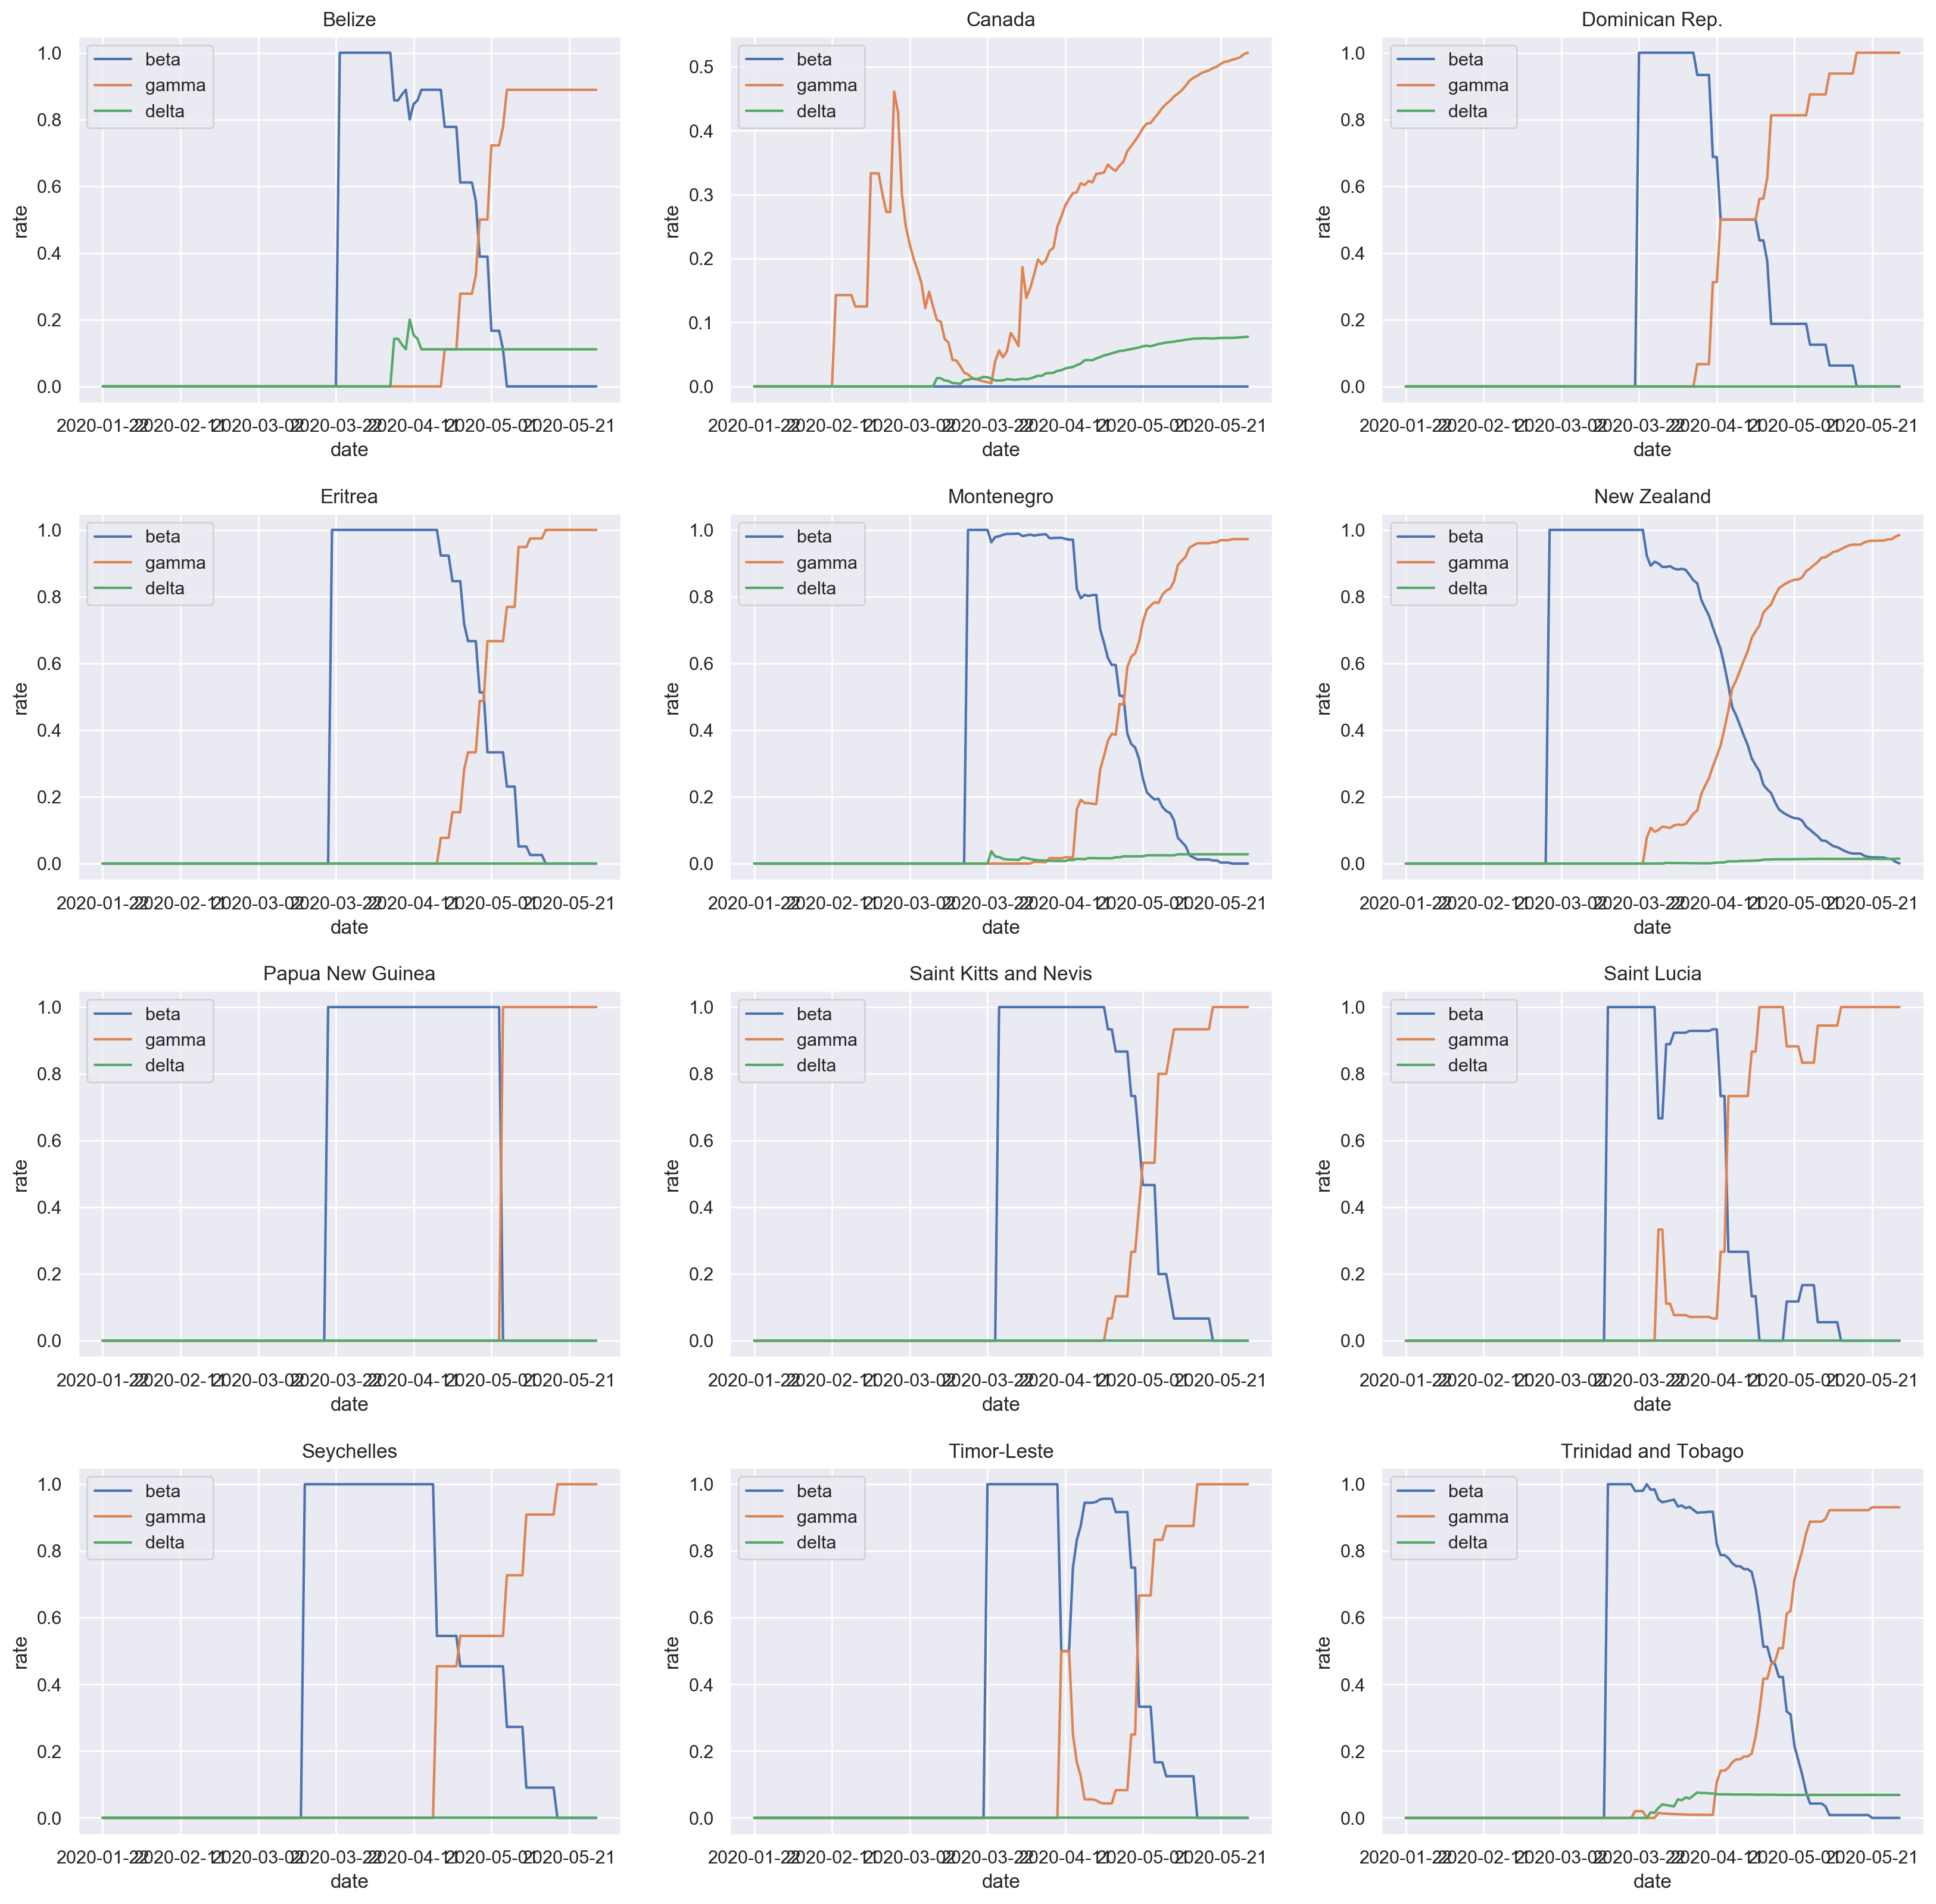

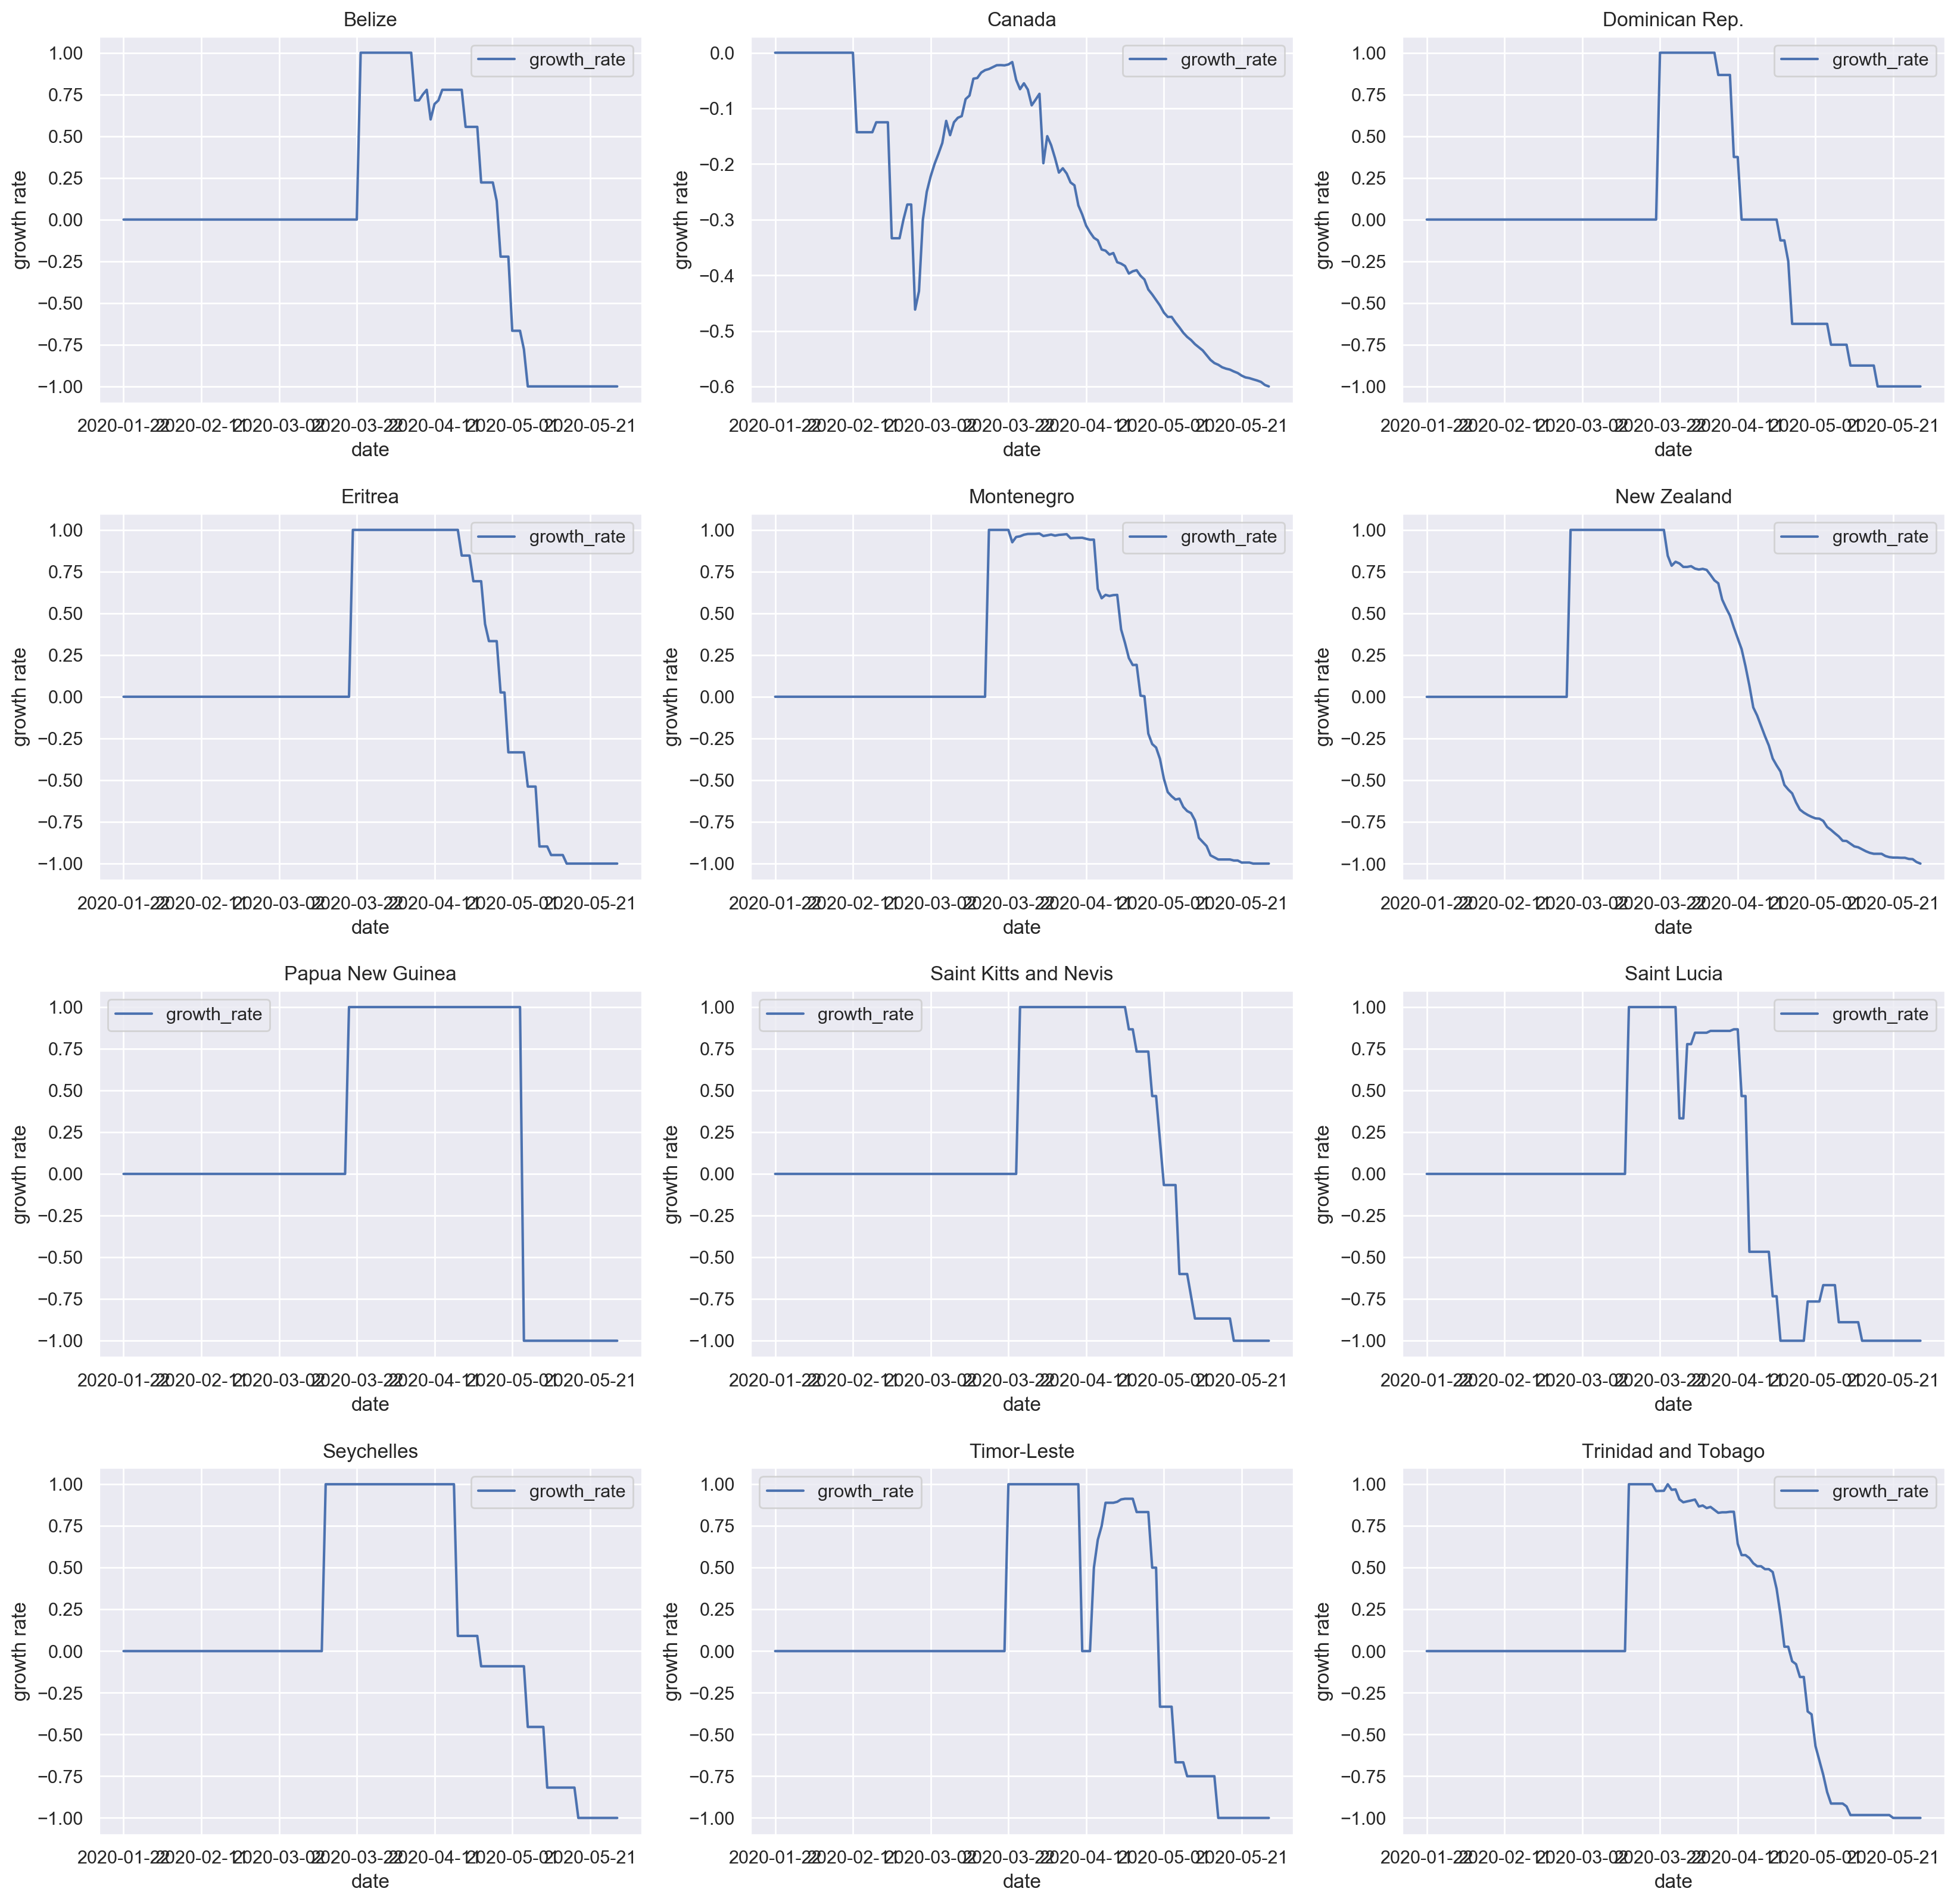

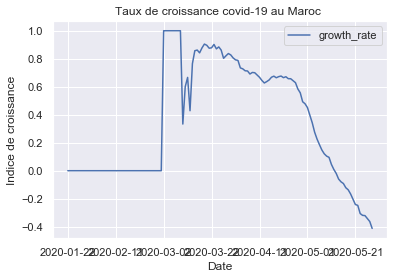

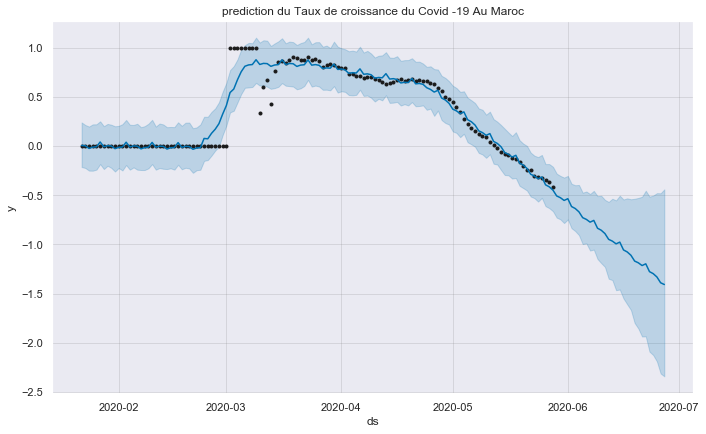

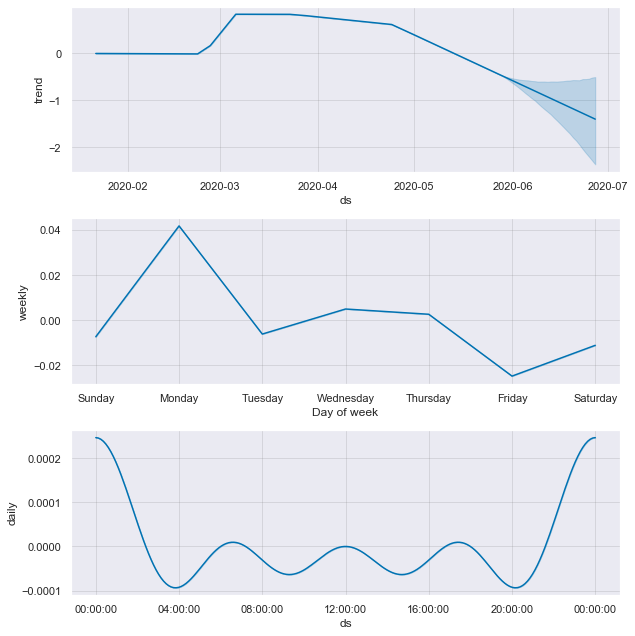

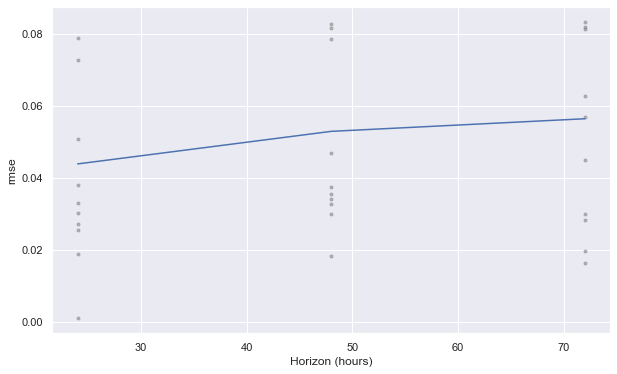

In [1]:

# Importation des libraires
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels as sm
import folium as fl
from pathlib import Path
from sklearn.impute import SimpleImputer
import geopandas as gpd
import mapclassify as mpc
import warnings
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

"""
Prédire la fin de l'épidémie
Détails des tâches

Prédisez comment les gens vont récupérer (en supposant qu'aucun remède n'a été inventé) 
en fonction des anciens dossiers de récupération.

Dans ce cahier, nous prédisons comment l'épidémie se terminera par la recherche du comportement à temps du taux d'infection ou du taux de transmission, 
du taux de récupération et du taux de décès ou du taux de mortalité.
Notre travail est le suivant:
"""
"""
-Bref examen du taux de contact et de l'incidence adéquats
    Modèle SIRF avec incidence standard adaptée
    Ajuster pratiquement les données au modèle SIRF
    Estimer 𝛽 (𝑡), 𝛾 (𝑡), 𝛿 (𝑡)
-La maladie s'éteint et trouve 𝑅0 (𝑡)
-Confirmé cumulatif, récupéré, décès et courant confirmé
-Calculer 𝛽 (𝑡), 𝛾 (𝑡), 𝛿 (𝑡), 𝑅0 (𝑡)
-Prévision
"""
"""
Taux de contact et incidence adéquats
Le taux de contact 𝑈(𝑁) est le nombre de personnes contactées par infectieux par unité de temps.
Supposons que la probabilité d'infection par chaque contact soit 𝛽0, alors le taux de contact adéquat est 𝛽0 𝑈(𝑁).

Le taux de contact adéquat moyen d'un individu infecté à un sensible est 𝛽0 𝑈(𝑁)*𝑆/𝑁. 
Ce taux est appelé taux d'infection. Ensuite, 
le nombre total de nouveaux infectieux infectés par tous les individus dans 
le compartiment infecté par unité de temps, au temps t est (𝛽0 𝑈(𝑁)*𝑆/𝑁)*𝐼, qui est appelé incidence de la maladie.

Si 𝑈(𝑁) = 𝑘𝑁 c'est-à-dire que le taux de contact est proportionnel à la taille totale de la population,
l'incidence est 𝛽(𝑡) 𝑆(𝑡) 𝐼(𝑡), où 𝛽 = 𝛽0 𝑘 est appelé coefficient de transmission (taux de transmission) .
Ce type d'incidence est appelé incidence bilinéaire
Si 𝑈(𝑁) = 𝑘′, c'est-à-dire que le taux de contact est une constante dans ce cas,
l'incidence devient 𝛽𝐼 𝑆/𝑁, où 𝛽 = 𝛽0 𝑘′, et elle est appelée incidence standard.
Extrait de: Zhien Ma, Jia Li - Modélisation dynamique et analyse de l'épidémie-World Scientific Publishing Company (2009)
Modèle SIRF avec incidence standard adaptée
Peut-on trouver le modèle qui explique bien la propagation de covid 19 dans le monde?

Nous savons que covid19 a de nombreuses variables importantes mais nos données,
nous avons quatre ConfirmedCases (TotalpositiveCases), CurrentConfirmedCases (CurrentpositiveCases), Recovered et Deaths.
Comment obtenir l'équation du système dynamique pour ces variables?
Pour répondre à cette question, nous allons utiliser le modèle SIRF à incidence standard:

Le modèle SIRF à incidence standard est un modèle classique en épidémiologie, 
il contient 04 sous-populations, les sensibles S, les infectieux I et les individus récupérés R, les décès F:

Susceptiles

Infectieux

Rétabli

Victimes
Le sensible peut devenir infectieux, et les infectieux peuvent être récupérés ou tués, 
mais aucune autre transition n'est envisagée. 
La population 𝑁 = 𝑆 + 𝐼 + 𝑅 + 𝐹 reste constante.
Le modèle décrit le mouvement entre les classes par le système d'équations différentielles.
𝑑𝑆/𝑑𝑡=−𝛽𝐼 𝑆/𝑁 ,  𝑑𝐼/𝑑𝑡=𝛽𝐼 𝑆/𝑁−(𝛾+𝛿)𝐼,  𝑑𝑅/𝑑𝑡=𝛾𝐼  𝑑𝐹/𝑑𝑡=𝛿𝐼.
Où 𝛽 est le taux de transmission, 𝛾 est le taux de récupération, 𝛿 est le taux de décès

Ajuster pratiquement des données au modèle SIRF
Dans le contexte de sars cov 2 dans le monde, nous devons adapter le modèle SIRF à nos données afin
de pouvoir faire une approximation du comportement de la maladie et définir le taux de transmission et d'autres. 
Si nous considérons (N) le nombre de population dans une surface fixe (𝐾𝑚2) au temps t.
Nous savons qu'il existera une population de cas confirmés et une population de cas non confirmés.

taille de la population = total des cas positifs + cas totaux négatifs et cas total positifs = (récupérés + décès)

Par conséquent,

taille de la population = total de cas négatifs + cas positifs actuels + récupérés + décès (1)

À partir de (1), nous pouvons faire une identification:

la taille de la population peut être une population totale (N).

totalnegativecases peut être un sensible (S)

les cas positifs actuels peuvent être infectieux (I)

récupéré + la mort peut être une personne récupérée (R) + victimes (F)

On peut réécrire:

𝑆 = 𝑁 − 𝑆𝑐 → 𝑆𝑁 = 1 − 𝑆𝑐𝑁 si 𝑆𝑐𝑁 << 1 nous avons 𝑆≈𝑁 et le modèle SIRF avec incidence standard devient:

𝑑𝐼 / 𝑑𝑡 = (𝛽 − 𝛾 − 𝛿) 𝐼, 𝑑𝑅 / 𝑑𝑡 = 𝛾𝐼 𝑑𝐹 / 𝑑𝑡 = 𝛿𝐼

"""

import warnings
%matplotlib inline
pd.options.plotting.backend
pd.plotting.register_matplotlib_converters()
gpd.plotting.plot_linestring_collection
sns.set()
warnings.filterwarnings('ignore')
#importation des données
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_recovred = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

url_country_etat = 'https://raw.githubusercontent.com/datasets/covid-19/531c6dd8617cbd24b7cd378eb545d75b4d790dc6/data/time-series-19-covid-combined.csv'#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv
confirmed = pd.read_csv(url_confirmed, error_bad_lines=False)
recovered = pd.read_csv(url_recovred, error_bad_lines=False)
deaths= pd.read_csv(url_deaths, error_bad_lines=False)
covid19= pd.read_csv(url_country_etat, error_bad_lines=False)
#nettoyage et traitement de données 
confirmed.isnull().sum()[confirmed.isnull().sum()>0]
recovered.isnull().sum()[confirmed.isnull().sum()>0]
deaths.isnull().sum()[confirmed.isnull().sum()>0]
confirmed = confirmed.drop(columns='Province/State')
recovered = recovered.drop(columns='Province/State')
deaths = deaths.drop(columns='Province/State')

date = deaths.columns[4:] 
#list(set(confirmed.columns) - set(['Country/Region','Lat','Long']))
#calcul des casactifs
casactifs = pd.DataFrame()
casactifs['Country/Region'] = confirmed['Country/Region']
casactifs['Lat'] = confirmed['Lat']
casactifs['Long'] = confirmed['Long']

for c in date:
    casactifs[c] = confirmed[c] - recovered[c] - deaths[c]
    
#casactifs.head()
#cas cumulatifs confirmés
cum_confirmed = confirmed.groupby(['Country/Region','Lat','Long'])[date].agg('sum').reset_index()
cum_recovered = recovered.groupby(['Country/Region','Lat','Long'])[date].agg('sum').reset_index()
cum_deaths = deaths.groupby(['Country/Region','Lat','Long'])[date].agg('sum').reset_index()
cum_currentCase = casactifs.groupby(['Country/Region','Lat','Long'])[date].agg('sum').reset_index()
"""
import os
os.environ['PROJ_LIB'] = r'C:/ProgramData/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'

from mpl_toolkits.basemap import Basemap
lat_mean = cum_confirmed.Lat.mean()
long_mean = cum_confirmed.Long.mean()
v = cum_confirmed.copy()
def plot_covid19(v=None, c=None, title=None, date=date):

    fig = plt.figure(figsize=(20, 20))
    m = Basemap(projection = 'mill', lat_0=0, lon_0=0, epsg='4236')
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='gray',lake_color='aqua')
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    
    
    for i, r, in v.iterrows():
    
        size = round(np.log10( r[date[c]]))
    
        if size == 1 or size == 0:
            m.plot(r.Long, r.Lat, marker='o', c='r',  markersize=2, alpha=0.8, latlon=True)
        
        elif size == 2 or size == 3:
            m.plot(r.Long, r.Lat, marker='o', c='r',  markersize=size*4, alpha=0.8, latlon=True)
        
        elif size == 4 or size == 5:
            m.plot(r.Long, r.Lat, marker='o', c='r',  markersize=size*8, alpha=0.8, latlon=True)
        
        else:
            m.plot(r.Long, r.Lat, marker='o', c='r',  markersize=size*10, alpha=0.8, latlon=True)
        
    plt.scatter([], [], c='k', alpha=0.5, label = date[c])
    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Date', loc='best')
    plt.title('Sars Cov 2 {} over time in the worldwide'.format(title))
    
plot_covid19(v=cum_confirmed, c=len(date)-1, title='transmission')
plot_covid19(v=cum_deaths, c=len(date)-1, title='Mortality')
"""
#la Dynamique de transmission: 𝛽 (𝑡), 𝛾 (𝑡), 𝛿 (𝑡).
url_country_etat = 'https://raw.githubusercontent.com/datasets/covid-19/531c6dd8617cbd24b7cd378eb545d75b4d790dc6/data/time-series-19-covid-combined.csv'
covid19= pd.read_csv(url_country_etat, error_bad_lines=False,parse_dates=True)

covid19['Date'] = pd.DataFrame(covid19['Date'])
covid19['currentCase'] = covid19['Confirmed'] - covid19['Recovered'] - covid19['Deaths']
replace = ['Dem. Rep. Congo', "Côte d'Ivoire", 'Congo', 'United Kingdom', 'China','Central African Rep.',
          'Eq. Guinea','eSwatini','Bosnia and Herz.', 'S. Sudan', 'Dominican Rep.', 'W. Sahara',
          'United States of America']

name = ['Congo (Kinshasa)', 'Ivory Coast', 'Congo (Brazzaville)', 'UK', 'Mainland China', 
        'Central African Republic', 'Equatorial Guinea', 'Eswatini', 'Bosnia and Herzegovina', 'South Sudan',
       'Dominica', 'Western Sahara','US']

covid_data = covid19.drop(columns=['Province/State'])
covid_data = covid_data.replace(to_replace=name, value=replace)
# END Cleaning
def determinate_beta_gamma_delta(data=None):
    '''
        
        cette fonction calcule le taux de transmission, le taux de guérison et le taux de mortalité au fil du temps
        params: données
        retour: bêta, gamma, delta
    '''
    
    beta = []
    gamma = []
    delta = []
    
    for t in range(len(data.Date.values)):
        
        x = data.Confirmed.iloc[t]
        y = data.Deaths.iloc[t]
        z = data.Recovered.iloc[t]
        w = data.currentCase.iloc[t]
        
        if x == 0.0:
            beta.append(0)
            gamma.append(0)
            delta.append(0)
        else:
            beta_t = w/x
            gamma_t = z/x
            delta_t = y/x
            
            beta.append(beta_t)
            gamma.append(gamma_t)
            delta.append(delta_t)
            
    return np.array(beta), np.array(gamma), np.array(delta) 

print(dir(determinate_beta_gamma_delta))
data_cumm = covid_data.groupby(['Date','Country/Region'])\
['Confirmed','Deaths','Recovered','currentCase'].agg('sum').reset_index()

#data_cumm.head()
#data_cumm['Country/Region']
transmission, recovery, fatality = determinate_beta_gamma_delta(data=data_cumm)
transDynamics = pd.DataFrame()
transDynamics['date']  = data_cumm.Date
transDynamics['country'] = data_cumm['Country/Region']
transDynamics['beta']  = transmission
transDynamics['gamma'] = recovery
transDynamics['delta'] = fatality

#transDynamics[transDynamics['country']=='Morocco']
#Trouvez le pays qui a 𝛽 (𝑡) <0,001 'transmission'
country_low_beta = []
td = transDynamics[transDynamics.date == transDynamics.date.max()]
for i, r in td.iterrows():  
    if r[2] < 0.001:
        country_low_beta.append(r[1])

#country_low_beta
#print('Ce sont les pays dont le taux de transmission est inférieur à 0,001. Cela signifie que la maladie est en train de se terminer')
fid = plt.figure(figsize=(20,20), dpi=200)
fid.subplots_adjust(hspace=0.3, wspace=0.2)
for i in range(1, len(country_low_beta)+1):
    ax = fid.add_subplot(4,3,i)
    dc = transDynamics[transDynamics.country == country_low_beta[i-1]]
    dc.plot(x='date', ax=ax)
    ax.set_ylabel('rate')
    ax.set_title(country_low_beta[i-1]) 
    
#Trouver le taux de croissance de l'infection
#country_disease_dying = transDynamics[transDynamics.country==('Morocco')]
# we take only the countries that the disease is currently dying.
country_disease_dying = transDynamics[transDynamics.country.isin(country_low_beta)]
#country_disease_dying.tail()
country_disease_dying['growth_rate'] = country_disease_dying.beta - country_disease_dying.gamma -\
country_disease_dying.delta
#country_disease_dying.tail()
"""
fix = plt.figure(figsize=(20,20), dpi = 200)
fix.subplots_adjust(hspace=0.3, wspace=0.2)
for i in range(1, len(country_disease_dying)+1):
    ax = fix.add_subplot(4,3,i)
    dc = country_disease_dying[country_disease_dying.country == ('Morocco')]
    dc.plot(x='date', y = 'growth_rate', ax=ax)
    ax.set_ylabel('growth rate')
    ax.set_title(country_disease_dying[i-1])
"""
fix = plt.figure(figsize=(20,20), dpi = 200)
fix.subplots_adjust(hspace=0.3, wspace=0.2)
for i in range(1, len(country_low_beta)+1):
    ax = fix.add_subplot(4,3,i)
    dc = country_disease_dying[country_disease_dying.country == country_low_beta[i-1]]
    dc.plot(x='date', y = 'growth_rate', ax=ax)
    ax.set_ylabel('growth rate')
    ax.set_title(country_low_beta[i-1])  

#Prévision de la fin de la maladie: étude de cas MAroc
#maroc = country_disease_dying[country_disease_dying.country=='Morocco']
maroc = country_disease_dying = transDynamics[transDynamics.country=='Morocco']
country_disease_dying['growth_rate'] = country_disease_dying.beta - country_disease_dying.gamma -\
country_disease_dying.delta
#maroc.head()
#série chronologique du Maroc avec Prophète
obs_maroc = maroc[['date','growth_rate']]
#obs_maroc.tail()
ax=obs_maroc.plot(x='date', y = 'growth_rate',title='Taux de croissance covid-19 au Maroc ')
ax.set_ylabel("Indice de croissance R0")
ax.set_xlabel("Date")
prophet_maroc = obs_maroc.rename(columns={'date':'ds', 'growth_rate':'y'})
#prophet_maroc.tail()
mc = Prophet(interval_width=0.95,changepoint_prior_scale=1.05, yearly_seasonality=False, 
             daily_seasonality=True)
mc.fit(prophet_maroc)
futureDays = mc.make_future_dataframe(periods=30)
#futureDays.tail()
maroc_forecast =  mc.predict(futureDays)
maroc_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
graph = mc.plot(maroc_forecast)
plt.title('prediction du Taux de croissance du Covid -19 Au Maroc')
graph1 = mc.plot_components(maroc_forecast)
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
#for cross validation we are taking the range of our data 
df_cv = cross_validation(mc, initial='115 days', period='1 days', horizon = '3 days')
#df_cv.head(3)
df_p = performance_metrics(df_cv)
#df_p.head(3)
from fbprophet.plot import plot_cross_validation_metric
ufig = plot_cross_validation_metric(df_cv, metric='rmse')
"""
Conclusion 

Selon le résultat, on peut dire que la maladie est en train dans le sens de s'etteindre  (fin) si 𝛽 (𝑡) <0,001. 
A cette valeur, si j'ai 1000 cas confirmés au temps t, nous n'obtenons qu'un seul patient qui est le cas actuel.
Et aussi le taux de croissance est négatif, ce qui tend à - (1 + 𝛿𝑡ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑).
"""